## NBEATS: Predicción de MWH

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../src')

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler

In [74]:
sns.set(rc = {'figure.figsize':(20,5)})

In [13]:
DATASET_PATH = '../datasets/consumo_energetico_diario.csv'
VARIABLE     = 'mwh'

In [173]:
dataset = pd.read_csv(DATASET_PATH)
dataset.columns = dataset.columns.str.lower()

dataset['date'] = pd.to_datetime(dataset['dia'], format="%Y-%m-%d")
dataset         = dataset.drop(columns=['dia'])
dataset         = dataset.sort_values(by='date',ascending=True)

dataset = dataset[3500:]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2222 entries, 3500 to 5721
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   mwh     2222 non-null   float64       
 1   tmp     2222 non-null   float64       
 2   date    2222 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 69.4 KB


<Figure size 1440x360 with 1 Axes>

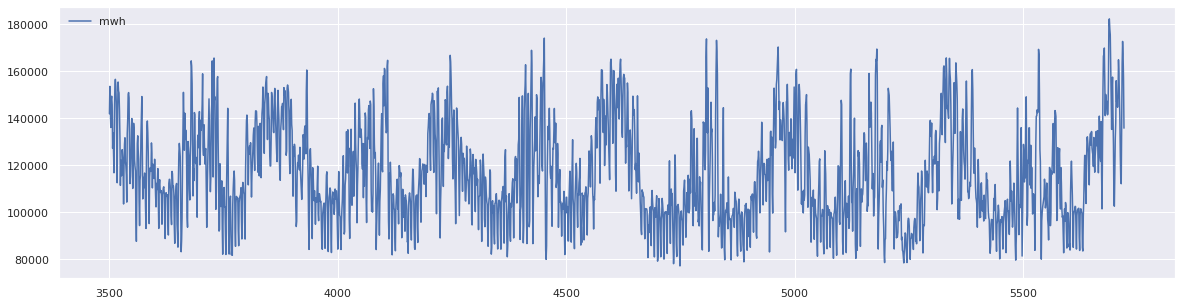

In [174]:
import matplotlib.pyplot as plt

dataset['mwh'].plot()
plt.legend();

In [199]:
mwh_ts = TimeSeries.from_dataframe(dataset, 'date', 'mwh')
tmp_ts = TimeSeries.from_dataframe(dataset, 'date', 'tmp')

<Figure size 1440x360 with 1 Axes>

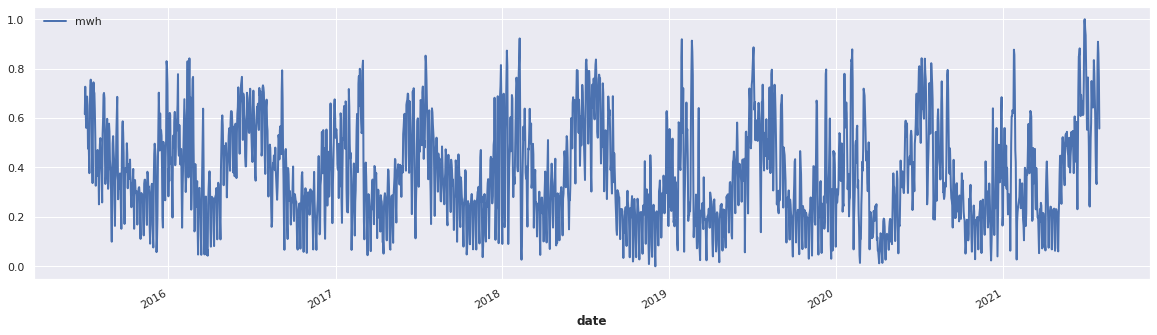

<Figure size 1440x360 with 1 Axes>

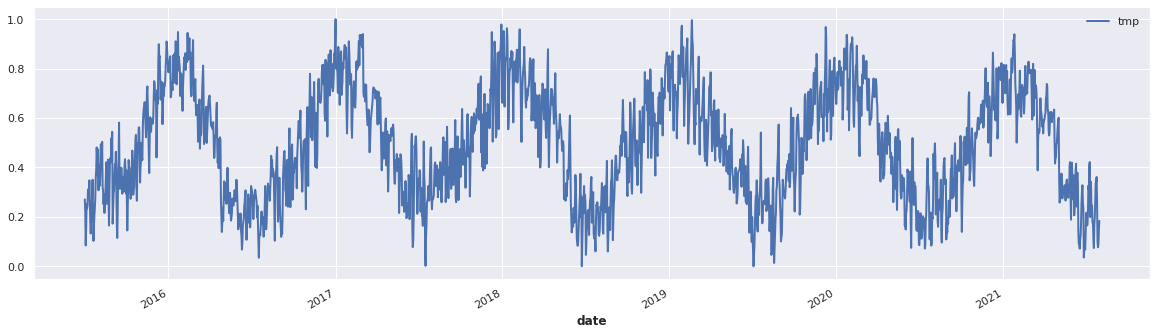

In [205]:
scaled_mwh_ts = Scaler().fit_transform(mwh_ts)
scaled_tmp_ts = Scaler().fit_transform(tmp_ts)

scaled_mwh_ts.plot()
plt.legend();
plt.show();
scaled_tmp_ts.plot()
plt.legend();
plt.show();

Train And Validation Split

In [208]:
mwh_train_set, mwh_val_set = scaled_mwh_ts[:-100], scaled_mwh_ts[-100:]
tmp_train_set, tmp_val_set = scaled_tmp_ts[:-100], scaled_tmp_ts[-100:]

In [213]:
model = NBEATSModel(
    input_chunk_length  = 200, 
    output_chunk_length = 30, 
    n_epochs            = 50,
    random_state        = 0,
    pl_trainer_kwargs   = {"accelerator": "gpu", "gpus": [0]}
)

In [214]:
model.fit([mwh_train_set, tmp_train_set], verbose=True)

/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
2022-09-11 21:47:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-09-11 21:47:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-11 21:47:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-11 21:47:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-11 21:47:24 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-09-11 21:47:24 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criter

Training: 0it [00:00, ?it/s]

2022-09-11 21:52:48 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


<darts.models.forecasting.nbeats.NBEATSModel object at 0x7f6a5b584d30>

2022-09-11 21:53:19 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 119it [00:00, ?it/s]

MAPE = 32.80%

<Figure size 1440x360 with 1 Axes>

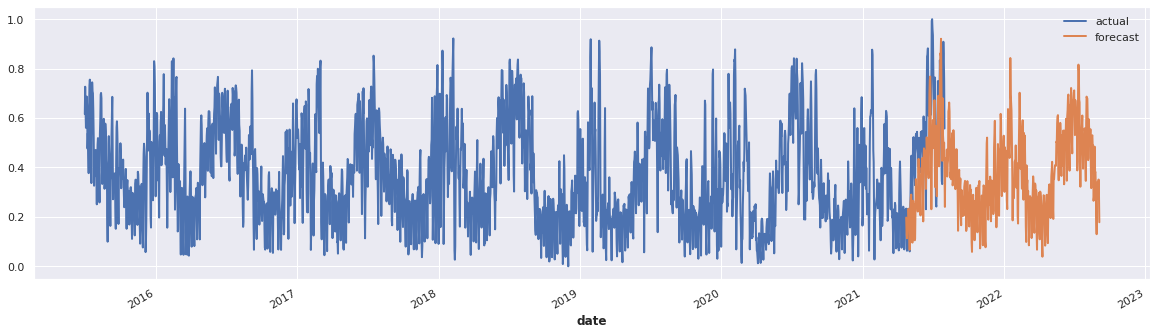

In [216]:
pred = model.predict(n=500, series=mwh_train_set)

scaled_mwh_ts.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(scaled_mwh_ts, pred)))

2022-09-11 21:53:28 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 119it [00:00, ?it/s]

MAPE = 58.15%

<Figure size 1440x360 with 1 Axes>

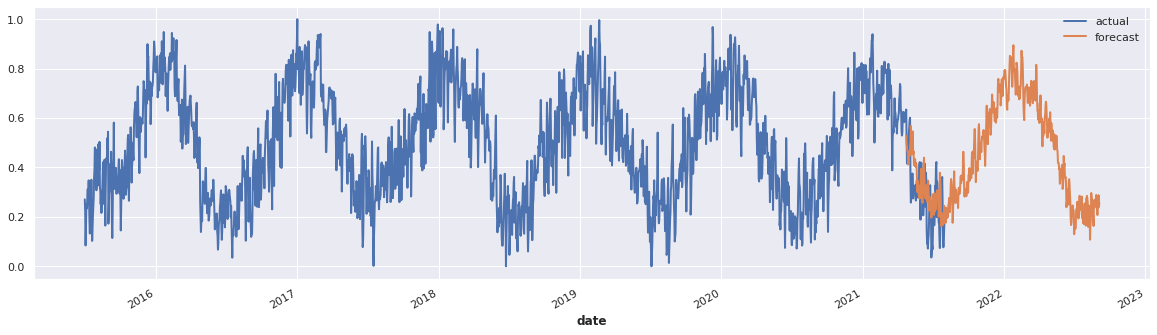

In [218]:
pred = model.predict(n=500, series=tmp_train_set)

scaled_tmp_ts.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(scaled_tmp_ts, pred)))